In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer, StandardScaler
from sklearn import model_selection, tree, neighbors, metrics, ensemble
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA

In [3]:
df_train= pd.read_csv('LFTS_train/train.csv')
df_test= pd.read_csv('LFTS_test.csv')

In [4]:
df_train['Employment.Type'].fillna(df_train['Employment.Type'].dropna().max(), inplace=True)
df_test['Employment.Type'].fillna(df_test['Employment.Type'].dropna().max(), inplace=True)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null object
Employment.Type                        233154 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                   

In [6]:
train=df_train.drop(['UniqueID','Date.of.Birth','DisbursalDate','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1)
test=df_test.drop(['UniqueID','Date.of.Birth','DisbursalDate','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1)

In [7]:
train.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,...,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,67,22807,45,1441,Salaried,6,1998,...,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,67,22807,45,1502,Self employed,6,1998,...,0,0,0,0,1991,0,0,1,0,1
2,53278,61360,89.63,67,22807,45,1497,Self employed,6,1998,...,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,67,22807,45,1501,Self employed,6,1998,...,0,0,0,0,31,0,0,0,1,1
4,52378,60300,88.39,67,22807,45,1495,Self employed,6,1998,...,0,0,0,0,0,0,0,0,1,1


In [8]:
le=LabelEncoder()
col=['PERFORM_CNS.SCORE.DESCRIPTION', 'Employment.Type', 'Employee_code_ID','branch_id','supplier_id','manufacturer_id','Current_pincode_ID']
for c in col:
    train[c]=le.fit_transform(train[c])
    test[c]=le.fit_transform(test[c])

0: 182543
1: 50611


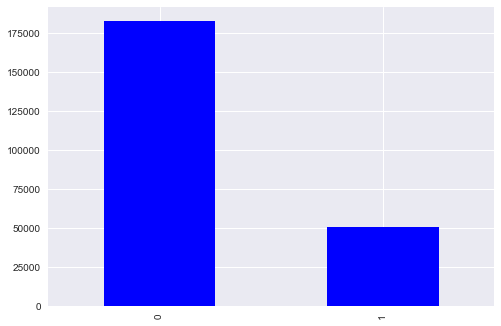

In [9]:
#apply resampling
target_count= train['loan_default'].value_counts()
target_count.plot(kind='bar')
print('0:',target_count[0])
print('1:',target_count[1])
plt.show()

In [10]:
count_0, count_1=train['loan_default'].value_counts()
train_0=train[train['loan_default']==0]
train_1=train[train['loan_default']==1]

In [11]:
df_under=train_0.sample(count_1)
df_under=pd.concat([df_under, train_1], axis=0)
df_under['loan_default'].value_counts()

1    50611
0    50611
Name: loan_default, dtype: int64

In [12]:
# df_over=train_1.sample(count_0, replace=True)
# df_over=pd.concat([df_over,train_0], axis=0)
# df_over['loan_default'].value_counts()

In [13]:
# y_over=df_over['loan_default']
# x_over=df_over.drop('loan_default', axis=1)
y_under=df_under['loan_default']
x_under=df_under.drop('loan_default', axis=1)

In [14]:
x_under.shape

(101222, 35)

In [15]:
#standard scaler on x and test
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x_under)
# Apply transform to both the training set and the test set.
x_scale= scaler.transform(x_under)
# x_over_scale= scaler.transform(x_over)
test = scaler.transform(test)

/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gagicha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/Users/gagicha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [16]:
#pca
pca = PCA(.95)
pca.fit(x_scale)
x_pca = pca.transform(x_scale)
test = pca.transform(test)

In [17]:
pca.n_components_

24

so from 35 columns, pca transformed data to 24 columns.

In [18]:
train_x, test_x, train_y, test_y= model_selection.train_test_split(x_pca, y_under, test_size=0.33)

In [19]:
test_y.value_counts()

1    16838
0    16566
Name: loan_default, dtype: int64

In [20]:
rf1=ensemble.RandomForestClassifier(min_samples_leaf=2, min_samples_split=10, n_estimators=1400)
rf1.fit(train_x, train_y)
print('acc: ',rf1.score(test_x, test_y))
pred_rf1=rf1.predict(test_x)
print('auc: ',metrics.roc_auc_score(test_y, pred_rf1))
print(metrics.confusion_matrix(test_y, pred_rf1))

acc:  0.5967848161896779
auc:  0.5968090299020528
[[9936 6630]
 [6839 9999]]


In [142]:
#hypertuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2100, num = 200)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
#                'bootstrap': bootstrap

In [143]:
rf = ensemble.RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_pca,y_under)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 39.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 502, 512, 522, 532, 542, 552, 562, 572, 582, 592, 602, 612, 62...2049, 2059, 2069, 2079, 2089, 2100], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dis

In [151]:
rf=rf_random.best_estimator_

In [156]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1406, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [150]:
rf_random.best_score_

0.41627314220228806

In [152]:
print('acc: ',rf.score(test_x, test_y))
pred_rf=rf.predict(test_x)
print('auc: ',metrics.roc_auc_score(test_y, pred_rf))
print(metrics.confusion_matrix(test_y, pred_rf))

acc:  0.9870674170757993
auc:  0.9870937313423419
[[16555   275]
 [  157 16417]]


In [153]:
out=pd.concat([df_test['UniqueID'], pd.DataFrame(rf.predict(test),columns=['loan_default'])], axis=1)

In [154]:
out.head()

,UniqueID,loan_default
0,655269,0
1,723482,1
2,758529,1
3,763449,0
4,708663,1


In [1]:
out.to_csv('loan_predict.csv', encoding='utf-8', index=False)

NameError: name 'out' is not defined